In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
import pyprind
from pydeeptoy.networks import *
from pydeeptoy.optimizers import *
from pydeeptoy.losses import *
from sklearn.metrics import accuracy_score

/Users/kirill/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
mnist = np.loadtxt('mnist/train.csv', delimiter=',', skiprows=1)

In [3]:
X = mnist[:, 1:]
y = mnist[:, 0]

In [4]:
X.shape

(42000, 784)

In [5]:
mnistMean, mnistStd = np.mean(X), np.std(X)
X = (X - mnistMean)/mnistStd

In [6]:
one_hot_y = np.array(LabelBinarizer().fit_transform(y).T)

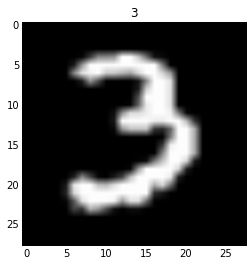

In [7]:
plt.imshow(X[9].reshape(28, 28), cmap='gray')
plt.title(np.argmax(one_hot_y[:, 9]))

In [ ]:
#X = X[:1000,:]
#one_hot_y = one_hot_y[:, :1000]
#y = y[:1000]

In [8]:
cg = ComputationalGraph()
x_in = cg.constant(name="X")
nn_output = neural_network(cg, x_in, X.shape[1], 100, 50, 10)
nn_output.name = "nn_output"
        
y_train = cg.constant(name="one_hot_y")
batch_size=256
loss = softmax(cg, nn_output, y_train, "loss_softmax")

ctx = SimulationContext()        

sgd = MomentumSgdOptimizer(learning_rate=0.01)
epochs = 200
bar = pyprind.ProgBar(epochs, bar_char='█', width=60, track_time=True, stream=1)
for epoch in range(0, epochs):
    indexes = np.arange(0, len(X))
    np.random.shuffle(indexes)
    train_x = X[indexes, :]
    train_y = one_hot_y[:, indexes]    
    for batch in range(0, len(train_x), batch_size):
        batch_x = train_x[batch:batch + batch_size]
        batch_y = train_y[:, batch:batch + batch_size]
        sgd.minimize(ctx, cg, {x_in: batch_x.T, y_train: batch_y})    
    bar.update(item_id = "loss = {0:.5f}".format(ctx[loss].value))

ctx.forward(cg, {x_in: X.T}, out=[nn_output])
y_pred = np.argmax(ctx[nn_output].value, axis=0)

accuracy = accuracy_score(y, y_pred)
accuracy

0%                                                        100%
[████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: loss = 0.00061
Total time elapsed: 00:03:49


1.0

In [9]:
Xtest = np.loadtxt('mnist/test.csv', delimiter=',', skiprows=1)
Xtest = (Xtest - mnistMean)/mnistStd

In [10]:
Xtest.shape

(28000, 784)

In [11]:
ctx.forward(cg, {x_in: Xtest.T, y_train: 1})
y_pred_test = np.argmax(ctx[nn_output].value, axis=0)

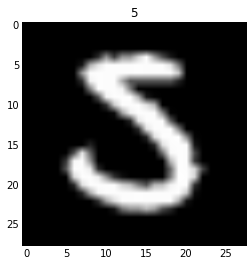

In [12]:
plt.imshow(Xtest[259].reshape(28, 28), cmap='gray')
plt.title(y_pred_test[259])

In [13]:
np.savetxt('mnist/pred.csv', np.column_stack((np.arange(len(y_pred_test)) + 1, y_pred_test)), 
           delimiter=',', header='ImageId,Label', fmt='%.d', comments='')